In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

(28, 28)


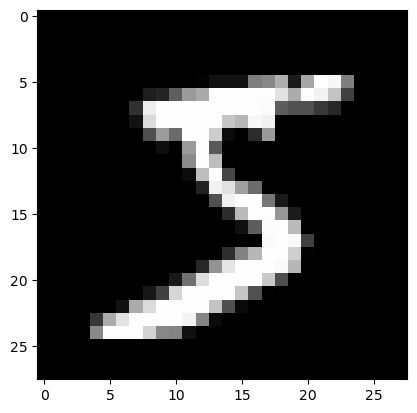

In [2]:
# load the dataset

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize with mean and std
])

train_dataset = datasets.MNIST(
    root='data',
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.MNIST(
    root='data',
    train=False,
    transform=transform,
    download=True
)

import matplotlib.pyplot as plt

img = train_dataset[0][0].numpy().squeeze()
img = (img - img.min()) / (img.max() - img.min())
print(img.shape)
plt.imshow(img, cmap='gray')

In [3]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

In [4]:
# define the generator - deconvolution network

import torch.nn as nn
from functools import reduce

class Generator(nn.Module):
    def __init__(self, final_size=28, num_deconv_layers=2, input_filters=128, output_filters=1, latent_size=100):
        super().__init__()
        self.input_filters = input_filters
        self.num_deconv_layers = num_deconv_layers
        self.orig_img_size = final_size // (2 ** num_deconv_layers)
        self.fc = nn.Linear(latent_size, self.orig_img_size * self.orig_img_size * input_filters, bias=True)
        self.relu = nn.ReLU()
        self.bn1d = nn.BatchNorm1d(self.orig_img_size * self.orig_img_size * input_filters)
        deconv_out_filters = reduce(lambda x, _: x + [x[-1] // 2], range(num_deconv_layers), [input_filters])
        deconv_out_filters[-1] = output_filters
        self.deconv_layers = nn.ModuleDict({f'deconv_{i}': nn.ConvTranspose2d(in_channels=deconv_out_filters[i], out_channels=deconv_out_filters[i+1], stride=2, kernel_size=4, padding=1) for i in range(num_deconv_layers)})
        self.bn2d_layers = nn.ModuleDict({f'bn_{i}': nn.BatchNorm2d(deconv_out_filters[i+1]) for i in range(num_deconv_layers-1)})
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        x = self.relu(self.bn1d(self.fc(x)))
        x = x.view(-1, self.input_filters, self.orig_img_size, self.orig_img_size)
        for idx, deconv in enumerate(list(self.deconv_layers.values())[:-1]):
            x = self.relu(self.bn2d_layers[f'bn_{idx}'](deconv(x)))
        return self.tanh(self.deconv_layers[f'deconv_{self.num_deconv_layers-1}'](x))

In [5]:
# define the discriminator - convolution network
from functools import reduce

class Discriminator(nn.Module):
    def __init__(self, num_initial_filters=64, num_conv_layers=2, initial_size=28):
        super().__init__()
        self.channels = [1] + list(reduce(lambda x, _: x + [x[-1]*2], range(num_conv_layers-1), [num_initial_filters]))
        self.conv_layers = nn.ModuleDict({f'conv_{i}': nn.Conv2d(in_channels=self.channels[i], out_channels=self.channels[i+1], kernel_size=4, stride=2, padding=1) for i in range(num_conv_layers)})
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.flatten = nn.Flatten()
        final_size = initial_size // (2 ** num_conv_layers)
        self.fc = nn.Linear(final_size * final_size * self.channels[-1], 1)
    
    def forward(self, x):
        for conv in self.conv_layers.values():
            x = self.leaky_relu(conv(x))
        x = self.flatten(x)
        return self.fc(x)

In [6]:
from torch.utils.data import Dataset

class HuggingFaceDataset(Dataset):
    def __init__(self, hf_dataset):
        self.dataset = hf_dataset

    def __len__(self):
        # Return the size of the dataset
        return len(self.dataset)

    def __getitem__(self, idx):
        # Access a single item by index
        item = self.dataset[idx][0]
        return item  # Return the raw data (customize as needed)

In [13]:
from torch.optim import Adam
from torch.utils.data import DataLoader, SubsetRandomSampler

from tqdm import tqdm
import random
random.seed(42)

class Trainer:
    def __init__(self, k, m, train_dataset):
        self.k = k
        train_dataset_size = len(train_dataset)
        random_indices = random.sample(range(train_dataset_size), train_dataset_size)
        sampler = SubsetRandomSampler(random_indices)
        self.train_dataloader = DataLoader(train_dataset, sampler=sampler, batch_size=m)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.generator = Generator().to(self.device)
        self.discriminator = Discriminator().to(self.device)
        self.generator_optim = Adam(self.generator.parameters())
        self.discriminator_optim = Adam(self.discriminator.parameters())
        self.loss_fn = nn.BCEWithLogitsLoss()
    
    def train(self, iterations):
        for _ in tqdm(range(iterations)):
            torch.cuda.empty_cache()
            sample = next(iter(self.train_dataloader))
            for _ in range(self.k):
                real_data = sample[0].to(self.device)
                noise_samples = torch.randn(real_data.size(0), 100).to(self.device)
                # print(real_data.shape, noise_samples.shape)
                self.train_discriminator(real_data, noise_samples)
            self.train_generator(noise_samples)

    def train_discriminator(self, real_data, noise_samples):
        # print(noise_samples.shape)
        fake_data = self.generator(noise_samples)
        # print(fake_data.shape)
        real_labels = torch.ones(real_data.size(0), 1).to(self.device)
        fake_labels = torch.zeros(fake_data.size(0), 1).to(self.device)
        real_output = self.discriminator(real_data)
        fake_output = self.discriminator(fake_data)
        # print(real_output.shape, fake_output.shape)
        real_loss = self.loss_fn(real_output, real_labels)
        fake_loss = self.loss_fn(fake_output, fake_labels)
        loss = real_loss + fake_loss
        self.discriminator_optim.zero_grad()
        loss.backward()
        self.discriminator_optim.step()
    
    def train_generator(self, noise_samples):
        fake_data = self.generator(noise_samples)
        fake_labels = torch.ones(fake_data.size(0), 1).to(self.device)
        fake_output = self.discriminator(fake_data)
        # print(fake_output.shape)
        loss = self.loss_fn(fake_output, fake_labels)
        self.generator_optim.zero_grad()
        loss.backward()
        self.generator_optim.step()

In [18]:
# train_hf_dataset = HuggingFaceDataset(train_dataset)
trainer = Trainer(1, 100, train_dataset)
trainer.train(5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [13:13<00:00,  6.30it/s]


torch.Size([5, 1, 28, 28])
torch.Size([5, 1])
tensor([[-12.0144],
        [-12.1184],
        [-12.3565],
        [-12.7003],
        [-11.4122]], device='cuda:0')


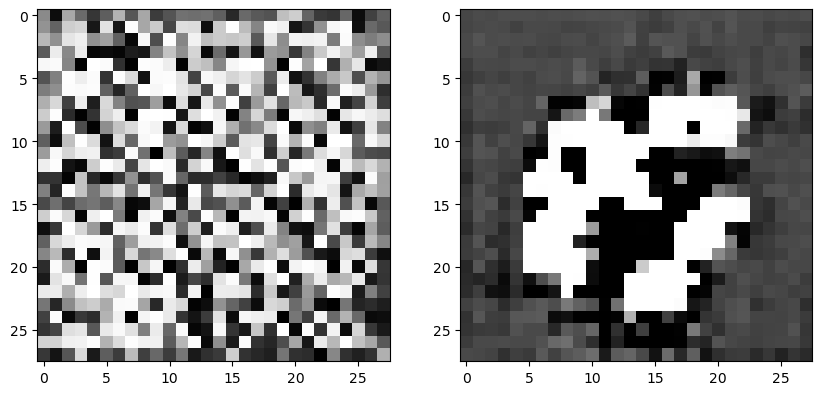

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

z = torch.randn(5, 100)
with torch.no_grad():
    gen = Generator()
    gen_imgs = gen(z)
    print(gen_imgs.shape)
    disc = Discriminator()
    disc_out = disc(gen_imgs)
    print(disc_out.shape)
    plt.subplot(1, 2, 1)
    plt.imshow(gen_imgs[0].cpu().numpy().squeeze(), cmap='gray')

with torch.no_grad():
    gen_imgs = trainer.generator(z.to(trainer.device))
    plt.subplot(1, 2, 2)
    plt.imshow(gen_imgs[0].cpu().numpy().squeeze(), cmap='gray')
    print(trainer.discriminator(gen_imgs))

In [75]:
len(train_dataset[0])

2

In [9]:
train_dataset_size = len(train_dataset)
# print(train_dataset_size)
random_indices = random.sample(range(train_dataset_size), train_dataset_size)
sampler = SubsetRandomSampler(random_indices)
train_dataloader = DataLoader(train_dataset, sampler=sampler, batch_size=100)

In [12]:
sample = next(iter(train_dataloader))
len(sample[0])

100

In [69]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [49]:
z = torch.randn(5, 100)
with torch.no_grad():
    gen = Generator()
    gen_imgs = gen(z)
    print(gen_imgs.shape)
    disc = Discriminator()
    disc_out = disc(gen_imgs)
    print(disc_out.shape)

torch.Size([5, 1, 28, 28])
torch.Size([5, 1])


torch.Size([5, 1, 28, 28])


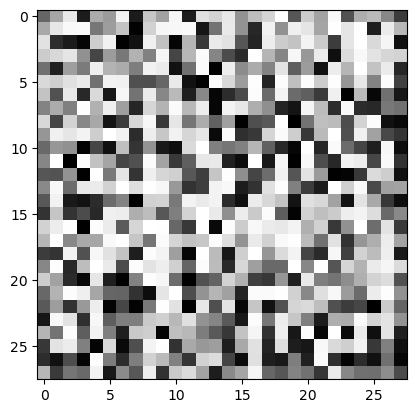

In [8]:
print(gen_imgs.shape)
plt.imshow(gen_imgs[0].squeeze().numpy(), cmap='gray')

torch.Size([5, 784])